## TODOS

1. How to handle multiple notes at same time-step? (e.g. chords, drumming)
2. How to handle note loudness?
3. How to handle silence?  
4. How to seed different predictions? 
5. Select `key` of song
6. How to handle sections (e.g. verse, chorus, etc.)?
	- Need to do `pattern analysis`

In [ ]:
import platform; platform.mac_ver()
# Should be 12.3 or greater, and 'arm64'

In [1]:
# External Imports
import matplotlib.pyplot as plt
import torch as torch
import numpy as np
import pypianoroll as pr

In [2]:
# Internal Imports
import sys, os
sys.path.append(os.path.abspath('/src'))

from src.util.types import Song, PianoState, NoteSample, PianoStateSamples
from src.util.globals import resolution, beats_per_bar, num_pitches, DEVICE
from src.util.convert import (
	convert_states_to_pianoroll,
 	convert_pianoroll_to_piano_states,
	output_piannoroll_to_midi
)
from src.util.plot import plot_pianoroll, plot_piano_states, plot_note_sample_probs, plot_track
from src.models import MusicRNN, MusicRNN_Batched
from src.models.train import train, train_batched
from src.models.infer import sample_notes

from src.dataset.load import (
    get_songs,
    load_multi_track,
    get_track_by_instrument,
    get_samples
)

# Pianoroll Dataset

## Loading Data

In [3]:
songs = get_songs()

# Reporting facts
non_zero_start_times = list(filter(
    lambda s: s.info['first_beat_time'] == 0,
	songs
))

const_time_signature = list(filter(
    lambda s: s.info['num_time_signature_change'] == 1,
	songs
))

print(f'% with zero start time: {len(non_zero_start_times)/len(songs)*100:.1f}')
print(f'% with constant time signature: {len(const_time_signature)/len(songs)*100:.1f}')

Found 21425 total files
% with zero start time: 100.0
% with constant time signature: 100.0


In [ ]:
# TESTING
if False:
	desired_instrument = 'Guitar'

	# EXAMPLE: Load a NPZ file into a Multitrack object.
	multi_track = load_multi_track(f'A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.npz')
	pr.plot_multitrack(multi_track, axs=None, mode='blended')

	track = get_track_by_instrument(multi_track, desired_instrument)

	if track:
		plot_track(track, desired_instrument, True, 4)
	else:
		print('No track found')

## Create the model

In [ ]:
model = MusicRNN(
    hidden_size=128,
    num_pitches=129,  # 0-128 notes (including silence at 0)
    num_layers=2,
    dropout=0.1
)

model = model.to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

In [6]:
batched_model = MusicRNN_Batched(
	hidden_size=128,
    num_pitches=129,  # 0-128 notes (including silence at 0)
    num_layers=2,
    dropout=0.1
)

batched_model = batched_model.to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in batched_model.parameters())}")

Model parameters: 66178


## Testing (toy data)

In [ ]:
# Create some simple test sequences
test_seq_1 = torch.Tensor([
	[1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10],
    [4, 10],
    [3, 10],
    [2, 10],
    [1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10],
    [4, 10],
    [3, 10],
    [2, 10],
    [1, 10],
]).float()

test_seq_2 = torch.Tensor([
	[1, 10],
	[2, 10],
 	[3, 10],
  	[4, 10],
   	[5, 10]
]).float()

In [ ]:
# TEST Overfit on 1 sequence

seq = test_seq_1
start_notes = seq[0]
max_len = 100

if False:
	train(model, [seq], num_epochs=3000, lr=0.0001)

	# Test sampling a sequence
	piano_state_samples = sample_notes(model, start_notes, max_len)

	plot_piano_states(seq, None, 'Real Sequence')
	plot_piano_states(piano_state_samples.piano_states, None, 'Generated Sequence')
	plot_note_sample_probs(piano_state_samples.note_samples)

In [ ]:
# Test Packed Model
seqs = [test_seq_1, test_seq_2]
start_notes = seqs[0][0]
max_len = 100

if False:
	train_batched(
     	batched_model,
      	seqs,
		batch_size=2,
       	num_epochs=1000,
        lr=0.0001
    )

In [ ]:
if False:
    # Test sampling a sequence
	piano_state_samples = sample_notes(
     	batched_model,
      	start_notes,
       	max_len,
		temperature=0.3
    )

	# plot_piano_states(seq, None, 'Real Sequence')
	plot_piano_states(piano_state_samples.piano_states, None, 'Generated Sequence')
	plot_note_sample_probs(piano_state_samples.note_samples)

## Testing (Real Data)

In [8]:
dataset = get_samples(songs, 'Guitar', 32)
tensors = [ torch.Tensor(seq).to(DEVICE) for seq in dataset ]

In [9]:
if True:
	train_batched(
		batched_model,
		tensors,
		batch_size=10,
		num_epochs=1000,
		lr=0.001
	)

Epoch 0/1000, Loss = 142212457.0000
Epoch 1/1000, Loss = 142139685.0000
Epoch 2/1000, Loss = 142078901.0000
Epoch 3/1000, Loss = 142027905.0000
Epoch 4/1000, Loss = 141986238.0000
Epoch 5/1000, Loss = 141953064.0000
Epoch 6/1000, Loss = 141927393.0000
Epoch 7/1000, Loss = 141908202.5000
Epoch 8/1000, Loss = 141894471.5000
Epoch 9/1000, Loss = 141884818.0000
Epoch 10/1000, Loss = 141877232.5000
Epoch 11/1000, Loss = 141861964.0000
Epoch 12/1000, Loss = 141820752.0000
Epoch 13/1000, Loss = 141797636.0000
Epoch 14/1000, Loss = 141778263.0000
Epoch 15/1000, Loss = 141768896.5000
Epoch 16/1000, Loss = 141753629.0000
Epoch 17/1000, Loss = 141731482.5000
Epoch 18/1000, Loss = 141697611.5000
Epoch 19/1000, Loss = 141652838.0000
Epoch 20/1000, Loss = 141544482.5000
Epoch 21/1000, Loss = 141524451.0000
Epoch 22/1000, Loss = 141426065.0000
Epoch 23/1000, Loss = 141342219.5000
Epoch 24/1000, Loss = 141262699.0000
Epoch 25/1000, Loss = 141160859.5000
Epoch 26/1000, Loss = 141111798.5000
Epoch 27/10

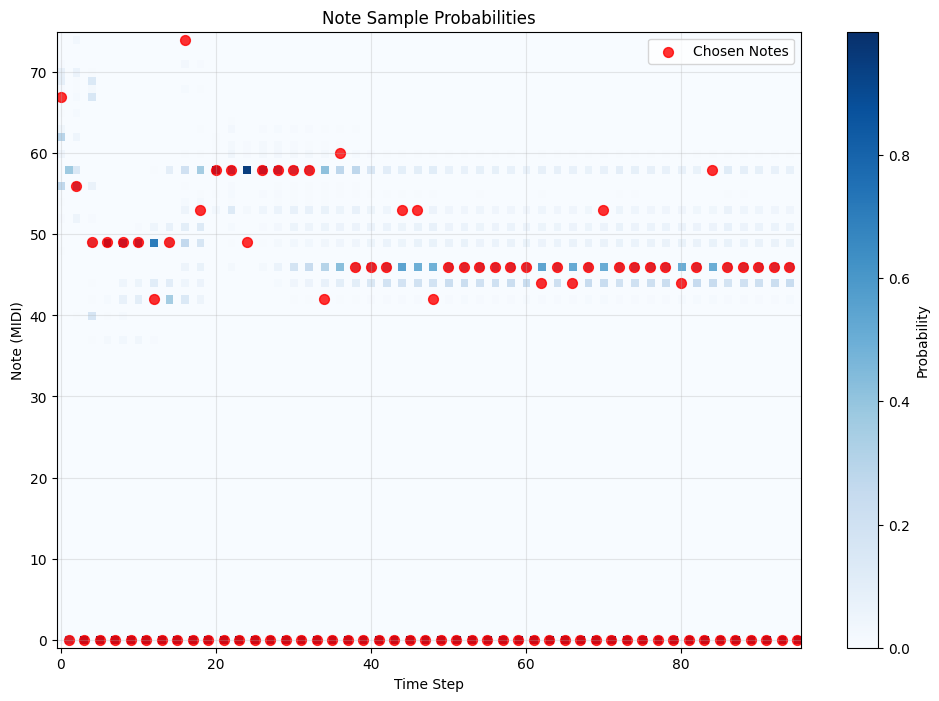

In [25]:
seq = dataset[0]
if True:
	predictions = sample_notes(
		batched_model,
		start_event=torch.Tensor(seq[0]),
		length=beats_per_bar*1,
		temperature=0.3
	)

	plot_note_sample_probs(predictions.note_samples)
	output_piannoroll_to_midi(
     	predictions.piano_states,
		instrument='Guitar',
     	name='generated_guitar2'
    )